In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from pyspark.sql.functions import *
from pyspark.sql.types import DateType
from pyspark.sql import SparkSession, DataFrame

In [2]:
sp = (
    SparkSession.builder.appName("Model")
    .config("spark.sql.session.timeZone", "+11")
    #.config("spark.driver.memory", "10g")
    #.config("spark.executor.memory", "10g")
    #.config('spark.sql.parquet.cacheMetadata', 'True')
    .getOrCreate()
)
sp

22/10/08 17:54:31 WARN Utils: Your hostname, J-L resolves to a loopback address: 127.0.1.1; using 172.28.113.244 instead (on interface eth0)
22/10/08 17:54:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/08 17:54:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
dataset = sp.read.option("inferSchema", True).parquet("../models/random_forest_output_full/")
dataset.show(1)

+-------+------------+--------------+-----------+-----------------+--------+------------------+-----------------+--------------+--------------+-------------+--------------+----------------------+----------+
|user_id|merchant_abn|order_datetime|Natural_var|Potential_Outlier|postcode|dayofmonth_encoded|dayofweek_encoded| month_encoded|  tags_encoded|state_encoded|gender_encoded|Earnings_Class_encoded|prediction|
+-------+------------+--------------+-----------+-----------------+--------+------------------+-----------------+--------------+--------------+-------------+--------------+----------------------+----------+
|  15204| 87639550697|    2022-05-22|          0|                0|    6625|    (30,[6],[1.0])|    (6,[1],[1.0])|(11,[9],[1.0])|(24,[4],[1.0])|(7,[2],[1.0])| (2,[0],[1.0])|         (4,[1],[1.0])|       1.0|
+-------+------------+--------------+-----------+-----------------+--------+------------------+-----------------+--------------+--------------+-------------+--------------+

In [4]:
selected = dataset.select("merchant_abn", "order_datetime", "postcode", "prediction")
selected.show(2)

+------------+--------------+--------+----------+
|merchant_abn|order_datetime|postcode|prediction|
+------------+--------------+--------+----------+
| 87639550697|    2022-05-22|    6625|       1.0|
| 57900494384|    2022-05-22|    1597|       1.0|
+------------+--------------+--------+----------+
only showing top 2 rows



In [5]:
avg_merchant_pred = selected.groupBy("merchant_abn").avg("prediction").toPandas()
avg_merchant_pred.head()

,merchant_abn,avg(prediction)
0,83412691377,1.0
1,73256306726,1.0
2,38700038932,1.0
3,73841664453,1.0
4,35344855546,1.0


In [14]:
date_of_fraud = selected.filter(col("prediction") > 1).toPandas()
date_of_fraud.head()

,merchant_abn,order_datetime,postcode,prediction
0,96152467973,2022-07-19,3186,9.0
1,89726005175,2022-07-25,3123,9.0
2,96152467973,2022-08-01,3123,9.0
3,57900494384,2022-03-19,3186,9.0
4,71787414647,2022-03-19,3186,9.0


In [15]:
date_of_fraud.count()

merchant_abn      838
order_datetime    838
postcode          838
prediction        838
dtype: int64

In [18]:
sns.set_style("whitegrid")
sns.set_palette("autumn")

In [23]:
consumer_fraud = pd.read_csv("../data/tables/consumer_fraud_probability.csv")
consumer_fraud.head()

,user_id,order_datetime,fraud_probability
0,6228,2021-12-19,97.629808
1,21419,2021-12-10,99.247380
2,5606,2021-10-17,84.058250
3,3101,2021-04-17,91.421921
4,22239,2021-10-19,94.703425


In [24]:
consumer_fraud["fraud_probability"] = np.floor(consumer_fraud["fraud_probability"] / 10)
consumer_fraud.head()

,user_id,order_datetime,fraud_probability
0,6228,2021-12-19,9.0
1,21419,2021-12-10,9.0
2,5606,2021-10-17,8.0
3,3101,2021-04-17,9.0
4,22239,2021-10-19,9.0


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

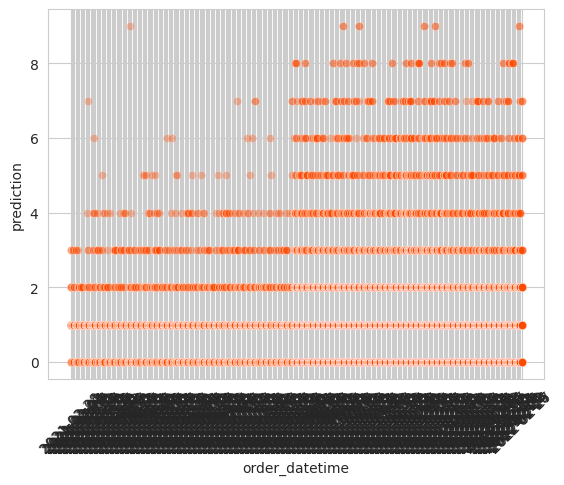

In [25]:
import matplotlib.pyplot as plt

sns.scatterplot(x="order_datetime", y="prediction", data=date_of_fraud.sort_values(by="order_datetime"), alpha=0.3)
sns.scatterplot(x="order_datetime", y="fraud_probability", data=consumer_fraud.sort_values(by="order_datetime"), alpha=0.3)
plt.xticks(rotation=45)


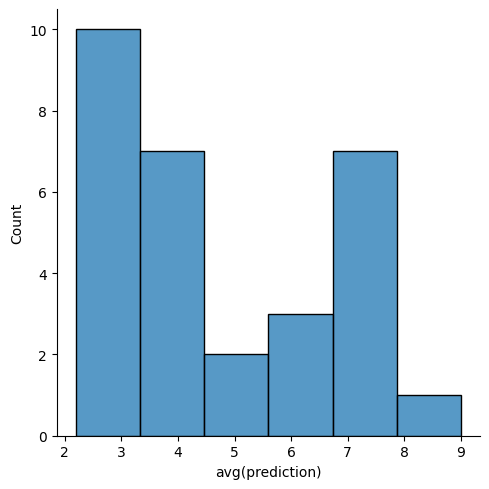

In [8]:
import seaborn as sns

sns.displot(avg_merchant_pred[avg_merchant_pred["avg(prediction)"] > 2]["avg(prediction)"])

In [10]:
postcodes = selected.groupBy("postcode").avg("prediction").toPandas()
postcodes.head(2)

,postcode,avg(prediction)
0,5556,1.0
1,4823,1.0


In [9]:
import folium
import geopandas as gpd

In [12]:
sf = gpd.read_file("../data/tables/SA2_2021_AUST_GDA2020.shp")
sf.head(2)

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
0,101021007,Braidwood,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,3418.3525,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4..."
1,101021008,Karabar,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,6.9825,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21899 -35.36738, 149.21800 -35.3..."


In [13]:
sf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2473 entries, 0 to 2472
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   SA2_CODE21  2473 non-null   object  
 1   SA2_NAME21  2473 non-null   object  
 2   CHG_FLAG21  2473 non-null   object  
 3   CHG_LBL21   2473 non-null   object  
 4   SA3_CODE21  2473 non-null   object  
 5   SA3_NAME21  2473 non-null   object  
 6   SA4_CODE21  2473 non-null   object  
 7   SA4_NAME21  2473 non-null   object  
 8   GCC_CODE21  2473 non-null   object  
 9   GCC_NAME21  2473 non-null   object  
 10  STE_CODE21  2473 non-null   object  
 11  STE_NAME21  2473 non-null   object  
 12  AUS_CODE21  2473 non-null   object  
 13  AUS_NAME21  2473 non-null   object  
 14  AREASQKM21  2454 non-null   float64 
 15  LOCI_URI21  2473 non-null   object  
 16  geometry    2454 non-null   geometry
dtypes: float64(1), geometry(1), object(15)
memory usage: 328.6+ KB


In [ ]:
geoJSON = sf[['POA_CODE21', 'geometry']].drop_duplicates("POA_CODE21").to_json()

m = folium.Map(location=[-22.15, 33.25], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on more information on how to plot aggregated data.
c = folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot
    data=postcodes, # data source
    columns=['postcode','avg(prediction)'], # the columns required
    key_on='properties.POA_CODE21', # this is from the geoJSON's properties
    fill_color='YlOrRd', # color scheme
    nan_fill_color='black',
    legend_name='average bnpl revenue from a transaction by postcode'
)
c.add_to(m)

m